# Phenotype classifcation using CellX 

This notebook shows how to take segmented time lapse microscopy images and use h2b fluorescence markers to classfiy mitotic state of the cell cycle. 

The sections of this notebook are as follows:

1. Load images
2. Localise the objects
3. Classify the objects
4. Batch process

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [1]:
from octopuslite import DaskOctopusLiteLoader
import btrack
from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import os
import glob
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load segmentation images

#### *Important*: from this point on you will need to be consistent with the use of cropping and alignment.
Using a previously generated alignment transformation will aid greatly in the tracking notebook, which depends on the object localisation performed in this notebook. Cropping your images will ensure that no border effects from the translational shift are seen.

In [2]:
# load images
expt = 'ND0011'
pos = 'Pos6'
root_dir = '/home/nathan/data'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_path = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy'
images = DaskOctopusLiteLoader(image_path, 
                               transforms=transform_path,
                               crop=(1200,1600), 
                               remove_background=False)

Using cropping: (1200, 1600)


## 2. Localise the objects

In [3]:
objects = btrack.utils.segmentation_to_objects(
    images['mask'],
    properties = ('area', ),
)

[INFO][2022/01/27 05:01:26 PM] Localizing objects from segmentation...
[INFO][2022/01/27 05:03:06 PM] Objects are of type: <class 'dict'>
[INFO][2022/01/27 05:03:06 PM] ...Found 6933 objects in 1638 frames.


In [4]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area
0,0,1410.627687,558.702494,0.0,0,False,0,5,0.0,1163


In [5]:
type(objects)

list

#### Can also assign measured values from raw image to each segment using `skimage.measure.regionprops` parameters
But also need to load the raw images to be measured first. Cannot currently save out `intensity_image` parameter to object file.

In [82]:
detailed_objects = btrack.utils.segmentation_to_objects(
    images['mask'], 
    images['gfp'],
    properties = ('area', 'mean_intensity', 'intensity_image'), 
)

[INFO][2022/01/25 04:47:33 PM] Localizing objects from segmentation...
[INFO][2022/01/25 04:47:33 PM] Found intensity_image data
[INFO][2022/01/25 04:47:33 PM] Calculating weighted centroids using intensity_image
[INFO][2022/01/25 04:52:07 PM] Objects are of type: <class 'dict'>
[INFO][2022/01/25 04:52:10 PM] ...Found 327022 objects in 1638 frames.


In [90]:
detailed_objects[69]

,ID,x,y,z,t,dummy,states,label,prob,area,mean_intensity,intensity_image
0,69,1517.610711,906.027849,0.0,1,False,0,5,0.0,1231,97.688871,"(43, 35) array"


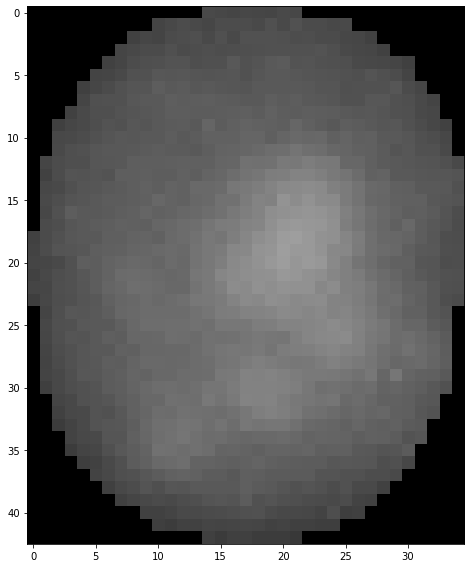

In [95]:
# example image showing PCNA-iRFP morphology 
imshow(detailed_objects[69].properties['intensity_image'])

## 3. Classify the objects 

Load model

In [58]:
model = load_model('./models/cellx_classifier_stardist.h5')

Define normalisation functions

In [60]:
def normalize_channels(x):

    for dim in range(x.shape[-1]):
        x[..., dim] = normalize(x[..., dim])
        
    return x

def normalize(x):

    xf = x.astype(np.float32)
    mx = np.mean(xf)
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])

    return (xf - mx) / sd

Define classifier function

In [27]:
def classify_objects(image, objects, obj_type=1):
    
    # define stages of cell cycle to classify (dependent on model type)
    LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]
    
    # iterate over frames
    for n in tqdm(range(image.shape[0])):
        
        # only select objects if in frame
        _objects = [o for o in objects if o.t == n]
        
        # empty placeholder arrays
        crops = []
        to_update = []
        
        # select h2b channel to aid in classification
        fp = gfp if obj_type == 1 else rfp
        
        # create stack by computing each frame of dask array input
        frame = np.stack(
            [image[n, ...].compute(), fp[n, ...].compute()], 
            axis=-1,) 
        
        # create padded image for network
        vol = InfinitePaddedImage(frame, mode = 'reflect')
        
        # iterate over objects 
        for obj in _objects:
            
            # create coords for image slice
            xs = slice(int(obj.x-40), int(obj.x+40), 1)
            ys = slice(int(obj.y-40), int(obj.y+40), 1)
            
            # crop image
            crop = vol[ys, xs, :]
            crop = resize(crop, (64, 64), preserve_range=True).astype(np.float32)
            
            # normalise image
            if crop.shape == (64 ,64, 2):
                crops.append(normalize_channels(crop))
                to_update.append(obj)
            else:
                print(crop.shape)
                
        if not crops:
            continue
            
        # use classifcation model to predict
        pred = model.predict(np.stack(crops, axis=0))
        
        # check correct number of predictions
        assert pred.shape[0] == len(_objects)
        
        # assign labels to objects
        for idx in range(pred.shape[0]):
            obj = _objects[idx]
            
            # assigning details of prediction
            pred_label = np.argmax(pred[idx, ...])
            pred_softmax = softmax(pred[idx, ...])
            logits = {f"prob_{k}": pred_softmax[ki] for ki, k in enumerate(LABELS)}
            
            # write out
            obj.label = pred_label
            obj.properties = logits

    return objects

#### Load raw images for classifier, a colour channel dependent on obj_type needed too (i.e. GFP is obj_type = 1, RFP is obj_type = 2)

In [25]:
bf = images['brightfield']
gfp = images['gfp']
rfp = images['rfp']

#### Classify objects

In [28]:
objects = classify_objects(bf, objects, obj_type = 1)

100%|██████████| 1638/1638 [03:05<00:00,  8.82it/s]


#### Inspect an example object

In [111]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area,prob_interphase,prob_prometaphase,prob_metaphase,prob_anaphase,prob_apoptosis
0,0,1410.627687,558.702494,0.0,0,False,0,0,0.0,1163,0.999992,3.588410e-09,6.128119e-10,1.724182e-10,0.000008


#### Save out classified objects

In [99]:
with btrack.dataio.HDF5FileHandler(
     f'{root_dir}/{expt}/{pos}/objects.h5', 'w', obj_type='obj_type_1',
) as hdf:
    hdf.write_segmentation(images['mask'])
    hdf.write_objects(objects)

[INFO][2022/01/25 05:17:30 PM] Opening HDF file: /home/nathan/data/ND0011/Pos6/segmented.h5...
[INFO][2022/01/25 05:20:21 PM] Writing objects/obj_type_1
[INFO][2022/01/25 05:20:22 PM] Writing labels/obj_type_1
[INFO][2022/01/25 05:20:22 PM] Loading objects/obj_type_1 (327022, 5) (327022 filtered: None)
[INFO][2022/01/25 05:20:25 PM] Writing properties/obj_type_1/area (327022,)
[INFO][2022/01/25 05:20:25 PM] Writing properties/obj_type_1/prob_interphase (327022,)
[INFO][2022/01/25 05:20:25 PM] Writing properties/obj_type_1/prob_prometaphase (327022,)
[INFO][2022/01/25 05:20:25 PM] Writing properties/obj_type_1/prob_metaphase (327022,)
[INFO][2022/01/25 05:20:25 PM] Writing properties/obj_type_1/prob_anaphase (327022,)
[INFO][2022/01/25 05:20:26 PM] Writing properties/obj_type_1/prob_apoptosis (327022,)
[INFO][2022/01/25 05:20:26 PM] Closing HDF file: /home/nathan/data/ND0011/Pos6/segmented.h5


# 4. Batch process
Iterate over many experiments and positions (need to ensure you define normalisation and classification functions above first)

In [ ]:
root_dir = '/home/nathan/data'
expt_list = ['ND0009', 'ND0010', 'ND0011']
pos_list = 'all'
overwrite = False

for expt in expt_list:
    
        # Find all positions in that experiment, if pos_list is all then it finds all positions
        if pos_list == 'all':
            pos_list = [pos for pos in os.listdir(f'{root_dir}/{expt}') 
                    if 'Pos' in pos 
                    and os.path.isdir(f'{root_dir}/{expt}/{pos}')]  
            
        ### Iterate over all positions in that experiment
        for pos in pos_list:
            
            ### check if overwrite param is false check if raw directory already created and if type of transform file already exists and decide whether to skip pos
            if not overwrite and glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'):
                print(glob.glob(f'{root_dir}/{expt}/{pos}/*objects*.h5'), f'file found, skipping {expt}/{pos}')
                continue
                
            print(f'Starting {expt}/{pos}')
            # load segmentation images in efficient image generator style
            image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
            transform_path = f'{root_dir}/{expt}/{pos}/gfp_transform_tensor.npy'
            images = DaskOctopusLiteLoader(image_path, 
                                           transforms=transform_path,
                                           crop=(1200,1600), 
                                           remove_background=False)
            
            # ID the objects in each segmentation image and assign option properties to them
            objects = btrack.utils.segmentation_to_objects(
            images['mask'],
            properties = ('area', ),
            )
            
            # load classifcation model and define labels
            model = load_model('./models/cellx_classifier_stardist.h5')
            LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]

            # load images for classifcation
            bf = images['brightfield']
            gfp = images['gfp'] # or rfp = images['rfp'], dependent on cell type
            
            # classify objects
            print("Classifying objects")
            objects = classify_objects(bf, objects, obj_type = 1)
            
            # save out classified objects as segmentation h5 file
            with btrack.dataio.HDF5FileHandler(
                 f'{root_dir}/{expt}/{pos}/objectss.h5', 'w', obj_type='obj_type_1',
            ) as hdf:
                hdf.write_segmentation(images['mask'])
                hdf.write_objects(objects)
            
            print(f'Finished {expt}/{pos}')